# CSoM: Julia experiments with a toolkit like described in the book "Programming the Finite Element Method" by Smith & Griffiths. 

In [1]:
#Pkg.update()
versioninfo()
using CSoM, Gadfly, Docile

Julia Version 0.4.1


## Example 4.1 of "Programming the FEM" (PtFEM).

This is the first example program in the book.

### Currently each example in PtFEM consists of 2 Julia component: 

1. The input data, e.g. p4.1.1.jl
2. The programs as described in PtFEM, e.g. Program 4.1 is FE4_1.jl

As in the book, the programs are subdivided by chapter name (e.g. "StaticEquilibrium") in the "examples" sub-directory.

In [2]:
path = joinpath(Pkg.dir("CSoM"), "examples", "StaticEquilibrium")
include(path*"/FE4_1.jl")

Commit cbe1bee* (2015-11-08 10:33 UTC)
Platform Info:
  System: Darwin (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-4980HQ CPU @ 2.80GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Haswell)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.3


FE4_1 (generic function with 1 method)

### Discussion of the initial implementation of Example 4.1.

This version (FE4_1.jl) is an almost straight translation from Fortran to Julia (maybe with the exception of the inputs). All FEx_x.jl files are more or less straight translations.

These experiments are aimed at a next version (P4.1.jl) which contains a more Julia-based implementations, e.g. using Julia sparse matrices vs. the skyline format and using Julia (and underlying libraries) for solving the global matrix equations, e.g. y = A \ x. All Px_x.jl will be similarly be Julia based scripts, and Px_x_x.jl contain the corresponding input files.

### Made the number of elements and distributed load parameters

N: Number of elements (nxe) in :x direction (left to right)
F: Total of distributed load

In [3]:
N = 4;    
F = 5.0;

### Distribute the load

Distribute the total element loads over N+1 nodes. Assign half-load to both end points. Last line just ensures the type of dist_loads is concrete.

In [4]:
dist_loads = [[(i, [-F/N]) for i in 1:(N+1)];]
dist_loads[1] = (1, [-F/(2*N)])
dist_loads[size(dist_loads,1)] = (N+1, [-F/(2*N)])
dist_loads = convert(Vector{Tuple{Int64, Vector{Float64}}}, dist_loads)

5-element Array{Tuple{Int64,Array{Float64,1}},1}:
 (1,[-0.625])
 (2,[-1.25]) 
 (3,[-1.25]) 
 (4,[-1.25]) 
 (5,[-0.625])

Notice that in this example the x axis goes from left to right (not as in the book) and the distributed load is compressive. Clamped end is node 1.

In [5]:
data = Dict(
# Beam(ndim, np_types, nxe, nip, direction, finite_element(nod, nodof), axisymmetric)
  :element_type => Beam(1, 1, N, 1, :x, Line(2, 1), false),
  :properties => [1.0e5;],
  :x_coords => linspace(0, 1, (N+1)),
  :support => [(1, [0])],
  :loaded_nodes => dist_loads
);

In [6]:
m = FE4_1(data);

There are 4 equations and the skyline storage is 7.



In [7]:
m.displacements

5x1 Array{Float64,2}:
  0.0       
 -1.09375e-5
 -1.875e-5  
 -2.34375e-5
 -2.5e-5    

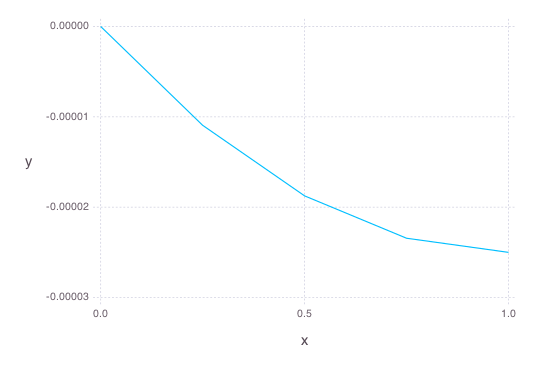

In [8]:
plot(x=data[:x_coords], y=m.displacements[:,1],Geom.line())

In [9]:
m.actions

4x2 Array{Float64,2}:
 4.375  -4.375
 3.125  -3.125
 1.875  -1.875
 0.625  -0.625

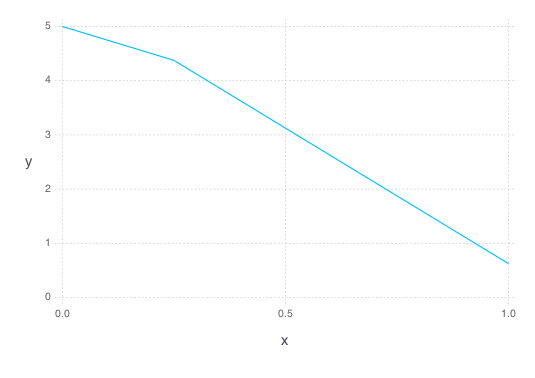

In [10]:
plot(x=data[:x_coords], y=[F; m.actions[:,1]],Geom.line())

### Step by step through FE4_1

Above the results using FE4_1.jl. Below goes through the steps in FE4_1.jl. Initial part just checks the input Dict.

In [11]:
if :element_type in keys(data)
    element_type = data[:element_type]
end

CSoM.Beam(1,1,4,1,:x,CSoM.Line(2,1),false)

For now this is modelled as a Beam although we only load axially, so it would more properly be a Rod element_type:

#### Beam(ndim, np_types, nxe, nip, direction, finite_element(nod, nodof), axisymmetric)

This is something I'm still thinking about. We could then drop several arguments (i.e. at least ndim, direction). For a 1D Rod the finite_element (Line(2, 1) is also trivial.

In [12]:
ndim = element_type.ndim
nst = element_type.nst;

In [13]:
# Add radial stress if element is 3d and axisymmetric
if ndim == 3 && element_type.axisymmetric
    nst = 4
end

In [14]:
element = element_type.element

CSoM.Line(2,1)

In [15]:
if typeof(element) == Line
    (nels, nn) = mesh_size(element, element_type.nxe)
elseif typeof(element) == Triangle || typeof(element) == Quadrilateral
    (nels, nn) = mesh_size(element, element_type.nxe, element_type.nye)
elseif typeof(element) == Hexahedron
    (nels, nn) = mesh_size(element, element_type.nxe, element_type.nye, element_type.nze)
end

(4,5)

In [16]:
nodof = element.nodof         # Degrees of freedom per node
ndof = element.nod * nodof    # Degrees of freedom per element

2

In [17]:
penalty = 1e20
if :penalty in keys(data)
    penalty = data[:penalty]
end

In [18]:
if :properties in keys(data)
    prop = zeros(size(data[:properties], 1), size(data[:properties], 2))
    for i in 1:size(data[:properties], 1)
        prop[i, :] = data[:properties][i, :]
    end
end

In [19]:
prop

1x1 Array{Float64,2}:
 100000.0

In [20]:
nf = ones(Int64, nodof, nn)
if :support in keys(data)
    for i in 1:size(data[:support], 1)
        nf[:, data[:support][i][1]] = data[:support][i][2]
    end
end
(size(nf), nf)

((1,5),
1x5 Array{Int64,2}:
 0  1  1  1  1)

In [21]:
x_coords = zeros(nn)
if :x_coords in keys(data)
    x_coords = data[:x_coords]
end
  
y_coords = zeros(nn)
if :y_coords in keys(data)
    y_coords = data[:y_coords]
end
  
z_coords = zeros(nn)
if :z_coords in keys(data)
    z_coords = data[:z_coords]
end

etype = ones(Int64, nels)
if :etype in keys(data)
    etype = data[:etype]
end

In [22]:
points = zeros(element_type.nip, ndim)
g = zeros(Int64, ndof)
g_coord = zeros(ndim,nn)
fun = zeros(element.nod)
coord = zeros(element.nod, ndim)
gamma = zeros(nels)
jac = zeros(ndim, ndim)
g_num = zeros(Int64, element.nod, nels)
der = zeros(ndim, element.nod)
deriv = zeros(ndim, element.nod)
bee = zeros(nst,ndof)
km = zeros(ndof, ndof)
mm = zeros(ndof, ndof)
gm = zeros(ndof, ndof)
kg = zeros(ndof, ndof)
eld = zeros(ndof)
weights = zeros(element_type.nip)
g_g = zeros(Int64, ndof, nels)
num = zeros(Int64, element.nod)
actions = zeros(nels, ndof)
displacements = zeros(size(nf, 1), ndim)
gc = ones(ndim, ndim)
dee = zeros(nst,nst)
sigma = zeros(nst)
axial = zeros(nels);

Ok, all arrays have been initialized. Time to start the real work. First determine the global numbering:

In [23]:
formnf!(nodof, nn, nf)
nf

1x5 Array{Int64,2}:
 0  1  2  3  4

In [24]:
neq = maximum(nf)

4

In [25]:
kdiag = zeros(Int64, neq)

4-element Array{Int64,1}:
 0
 0
 0
 0

In [26]:
ell = zeros(nels)
if :x_coords in keys(data)
    for i in 1:length(data[:x_coords])-1
        ell[i] = data[:x_coords][i+1] - data[:x_coords][i]
    end
end
ell

4-element Array{Float64,1}:
 0.25
 0.25
 0.25
 0.25

In [27]:
for i in 1:nels
    num = [i; i+1]
    num_to_g!(element.nod, nodof, nn, ndof, num, nf, g)
    g_g[:, i] = g
    fkdiag!(ndof, neq, g, kdiag)
end
g

2-element Array{Int64,1}:
 3
 4

In [28]:
kdiag

4-element Array{Int64,1}:
 1
 2
 2
 2

In [29]:
for i in 2:neq
    kdiag[i] = kdiag[i] + kdiag[i-1]
end
kdiag

4-element Array{Int64,1}:
 1
 3
 5
 7

In [30]:
kv = zeros(kdiag[neq])
gv = zeros(kdiag[neq])
print("There are $(neq) equations,")
println(" and the skyline storage is $(kdiag[neq]).\n")

There are 4 equations, and the skyline storage is 7.


In [31]:
loads = zeros(neq+1)
if :loaded_nodes in keys(data)
    for i in 1:size(data[:loaded_nodes], 1)
        loads[nf[:, data[:loaded_nodes][i][1]]+1] = 
            data[:loaded_nodes][i][2]
    end
end
nf

1x5 Array{Int64,2}:
 0  1  2  3  4

In [32]:
for i in 1:nels
    km = rod_km!(km, prop[etype[i], 1], ell[i])
    g = g_g[:, i]
    fsparv!(kv, km, g, kdiag)
end
kv

7-element Array{Float64,1}:
  800000.0
 -400000.0
  800000.0
 -400000.0
  800000.0
 -400000.0
  400000.0

In [33]:
fixed_freedoms = 0
if :fixed_freedoms in keys(data)
    fixed_freedoms = size(data[:fixed_freedoms], 1)
end
no = zeros(Int64, fixed_freedoms)
node = zeros(Int64, fixed_freedoms)
sense = zeros(Int64, fixed_freedoms)
value = zeros(Float64, fixed_freedoms)
if :fixed_freedoms in keys(data) && fixed_freedoms > 0
    for i in 1:fixed_freedoms
      node[i] = data[:fixed_freedoms][i][1]
      sense[i] = data[:fixed_freedoms][i][2]
      no[i] = nf[sense[i], node[i]]
      value[i] = data[:fixed_freedoms][i][3]
    end
    kv[kdiag[no]] = kv[kdiag[no]] + penalty
    loads[no+1] = kv[kdiag[no]] .* value
end
loads

5-element Array{Float64,1}:
 -0.625
 -1.25 
 -1.25 
 -1.25 
 -0.625

In [34]:
sparin!(kv, kdiag)
loads[2:end] = spabac!(kv, loads[2:end], kdiag)
loads

5-element Array{Float64,1}:
 -0.625     
 -1.09375e-5
 -1.875e-5  
 -2.34375e-5
 -2.5e-5    

In [35]:
displacements = zeros(size(nf))
for i in 1:size(displacements, 1)
    for j in 1:size(displacements, 2)
      if nf[i, j] > 0
        displacements[i,j] = loads[nf[i, j]+1]
      end
    end
end
displacements = displacements'

5x1 Array{Float64,2}:
  0.0       
 -1.09375e-5
 -1.875e-5  
 -2.34375e-5
 -2.5e-5    

In [36]:
loads[1] = 0.0
for i in 1:nels
    km = rod_km!(km, prop[etype[i], 1], ell[i])
    g = g_g[:, i]
    eld = loads[g+1]
    actions[i, :] = km * eld
end
actions

4x2 Array{Float64,2}:
 4.375  -4.375
 3.125  -3.125
 1.875  -1.875
 0.625  -0.625

In [37]:
m=FEM(element_type, element, ndim, nels, nst, ndof, nn, nodof, neq, penalty,
    etype, g, g_g, g_num, kdiag, nf, no, node, num, sense, actions, 
    bee, coord, gamma, dee, der, deriv, displacements, eld, fun, gc,
    g_coord, jac, km, mm, gm, kv, gv, loads, points, prop, sigma, value,
    weights, x_coords, y_coords, z_coords, axial);

In [38]:
m.displacements

5x1 Array{Float64,2}:
  0.0       
 -1.09375e-5
 -1.875e-5  
 -2.34375e-5
 -2.5e-5    

In [39]:
m.actions

4x2 Array{Float64,2}:
 4.375  -4.375
 3.125  -3.125
 1.875  -1.875
 0.625  -0.625